In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
# from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
import cv2
from sklearn.cluster import DBSCAN
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

pose_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_pose/session_pose_info'
os.makedirs(pose_analysis_session_data,exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)


embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps_new'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

In [2]:
session_filter_list = [
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

In [3]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]        
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [177]:
session_id = f'{session_filter_list[2]}-front'
case_study_input_cache_file = f"{case_study_input_data}/{session_id}.pb"
instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))


In [178]:
instructor_ids

array([ 4, 17, 18, 20, 22, 23, 25, 27, 28, 29, 31, 33, 34])

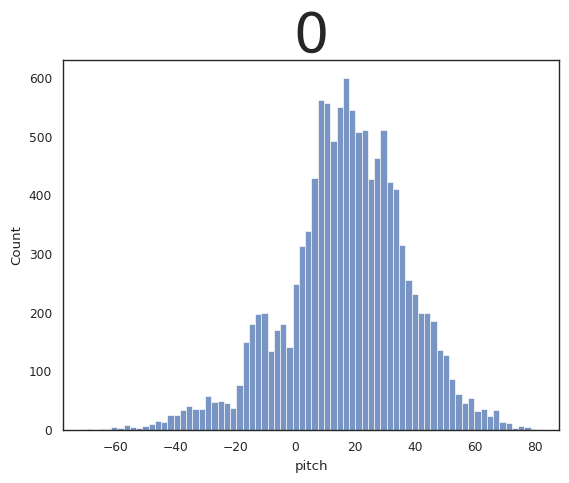

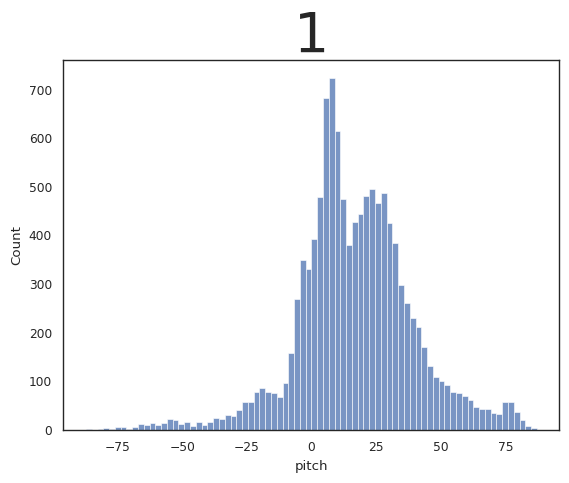

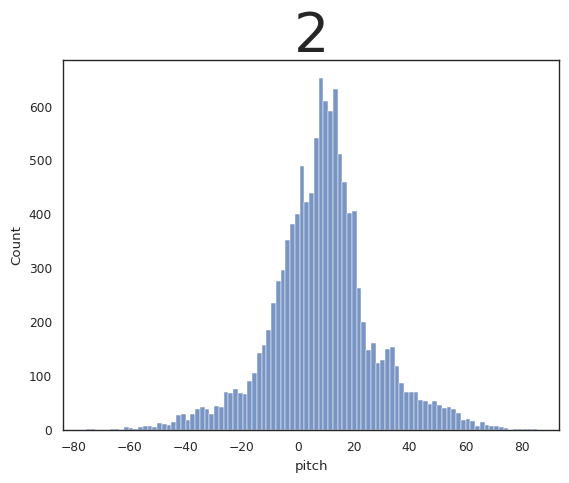

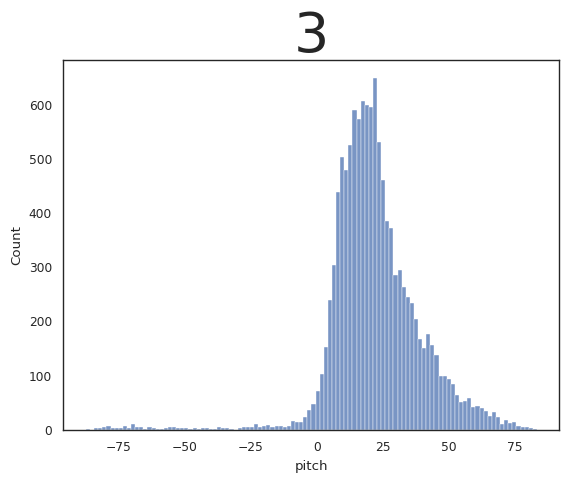

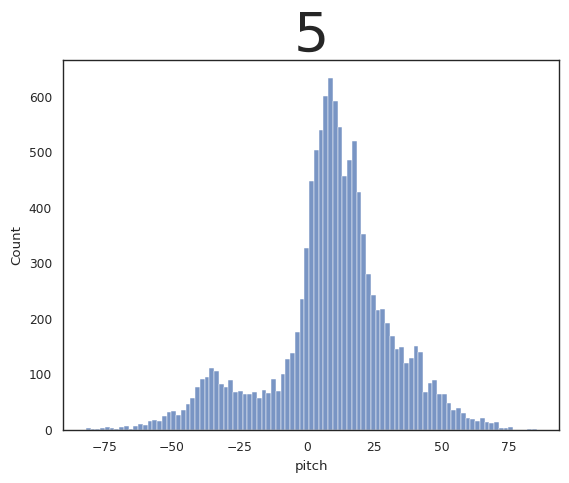

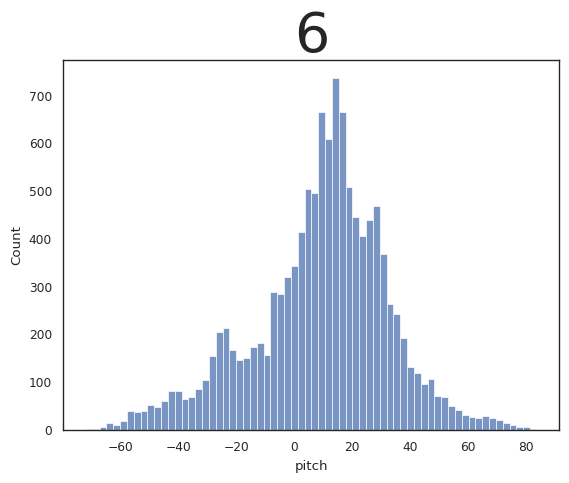

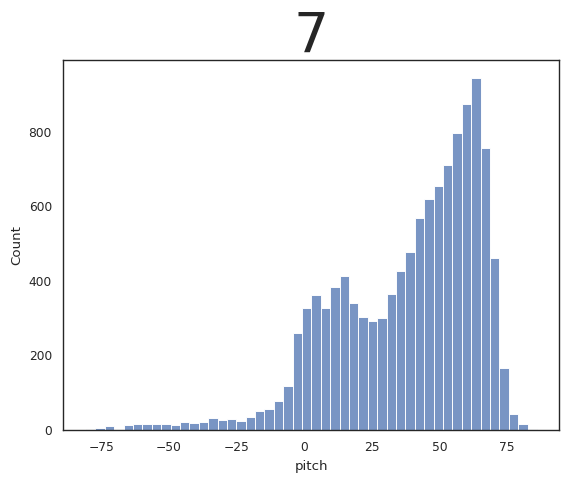

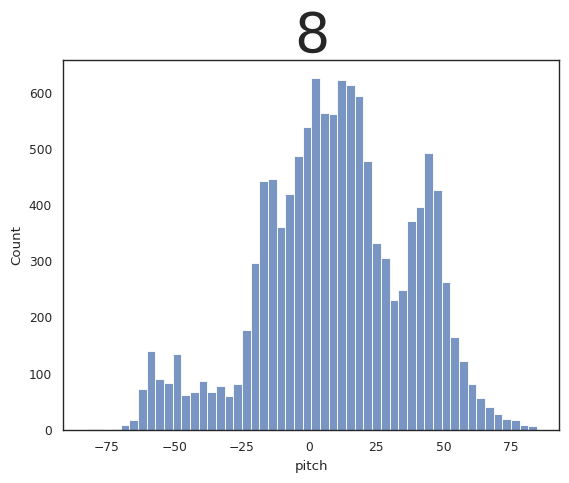

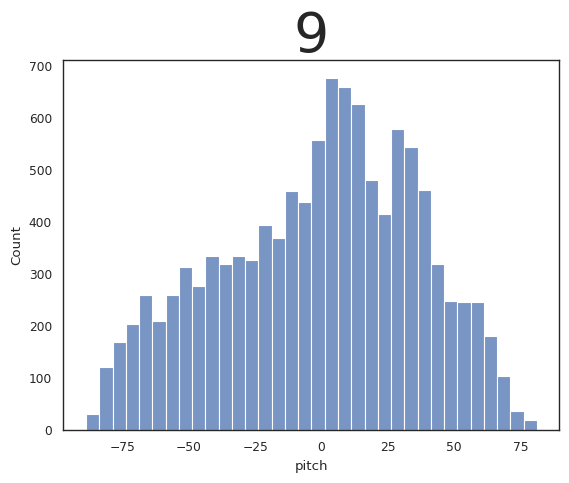

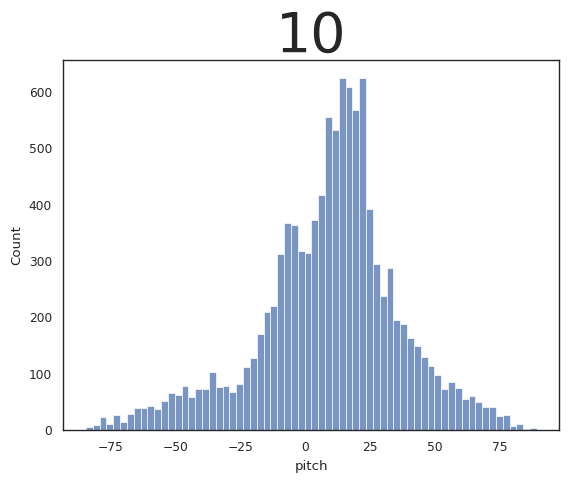

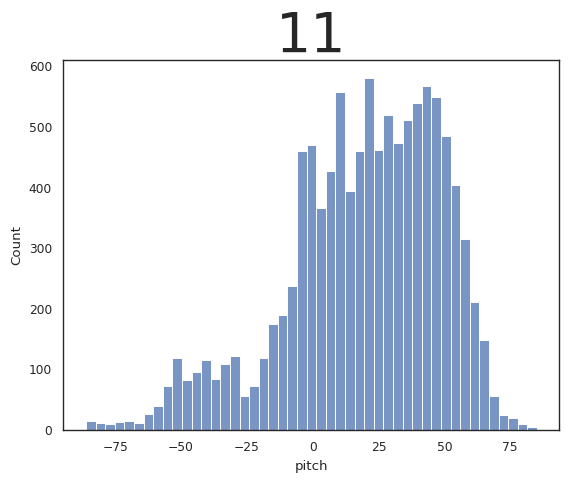

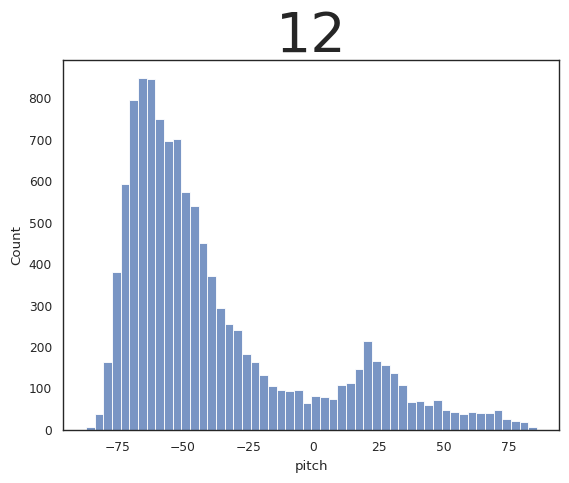

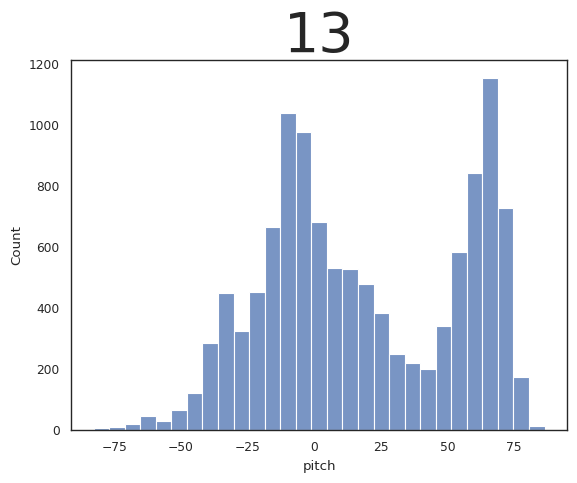

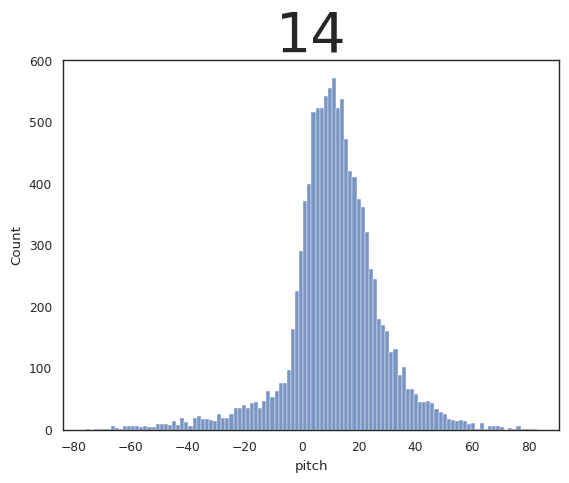

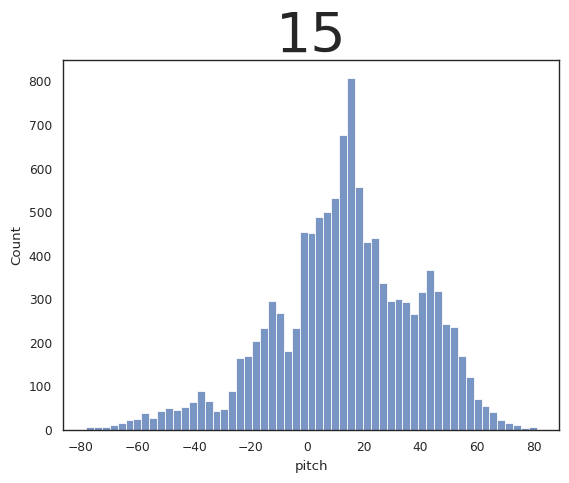

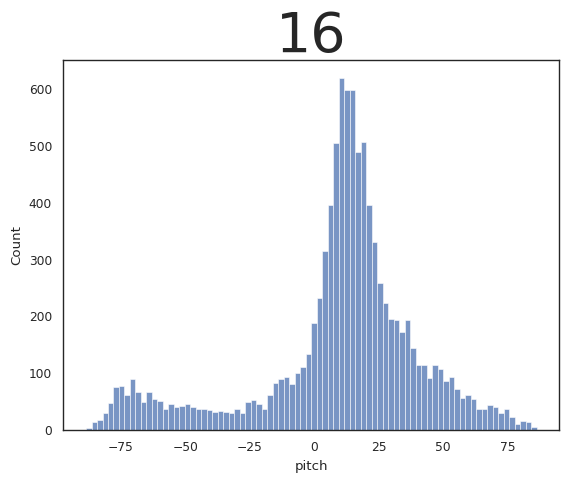

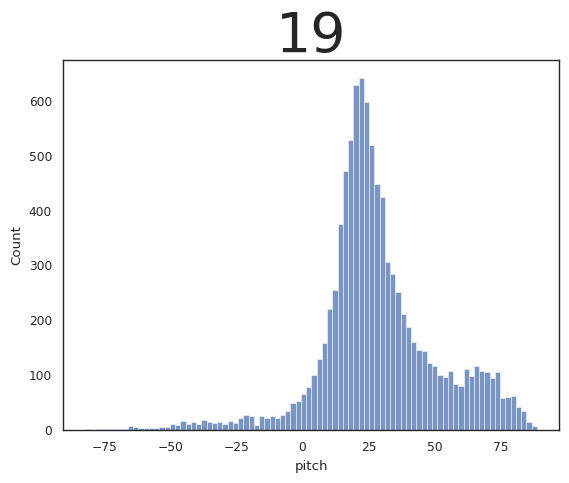

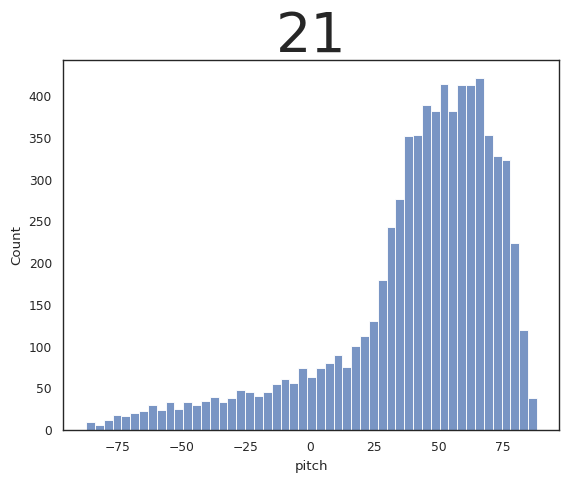

In [179]:
for sid in gaze_info:
    if sid not in instructor_ids:
        plt.figure()
        # sprint(sid)
        sns.histplot(gaze_info[sid].pitch)
        plt.title(sid,fontsize=40)
    

In [180]:
def frame_to_timestamp(frameNumber):
    return pd.to_timedelta(int(frameNumber*1000/15),unit='ms')
# frame_to_timestamp(70110)    

In [181]:


ts_data_dfs = []
sid_idx = 0
for sid in sorted(list(gaze_info.keys())):
    if sid not in instructor_ids:
        gaze_sid = deepcopy(gaze_info[sid]).reset_index()
        gaze_sid['time'] =gaze_sid['frame']//(10*15)
        gaze_sid['gaze_down'] = gaze_sid.pitch< -30
        gaze_sid = gaze_sid.groupby('time',as_index=False).agg({'gaze_down':lambda x: (x.sum()/x.shape[0]) >= 0.5})
        gaze_sid = gaze_sid[gaze_sid['gaze_down']==1]
        gaze_sid['StudentID'] = sid_idx
        sid_idx+=1
        gaze_sid = gaze_sid[['StudentID','time','gaze_down']]
        ts_data_dfs.append(gaze_sid)

df_gaze = pd.concat(ts_data_dfs)
df_gaze.shape

(761, 3)

In [184]:
df_gaze.to_csv('CS_2A_single_session.csv',index=False)

/tmp/ipykernel_39933/4102225370.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([pd.to_datetime(tm*10, unit='s').strftime('%H:%M') for tm in ax.get_xticks()], fontsize=10)


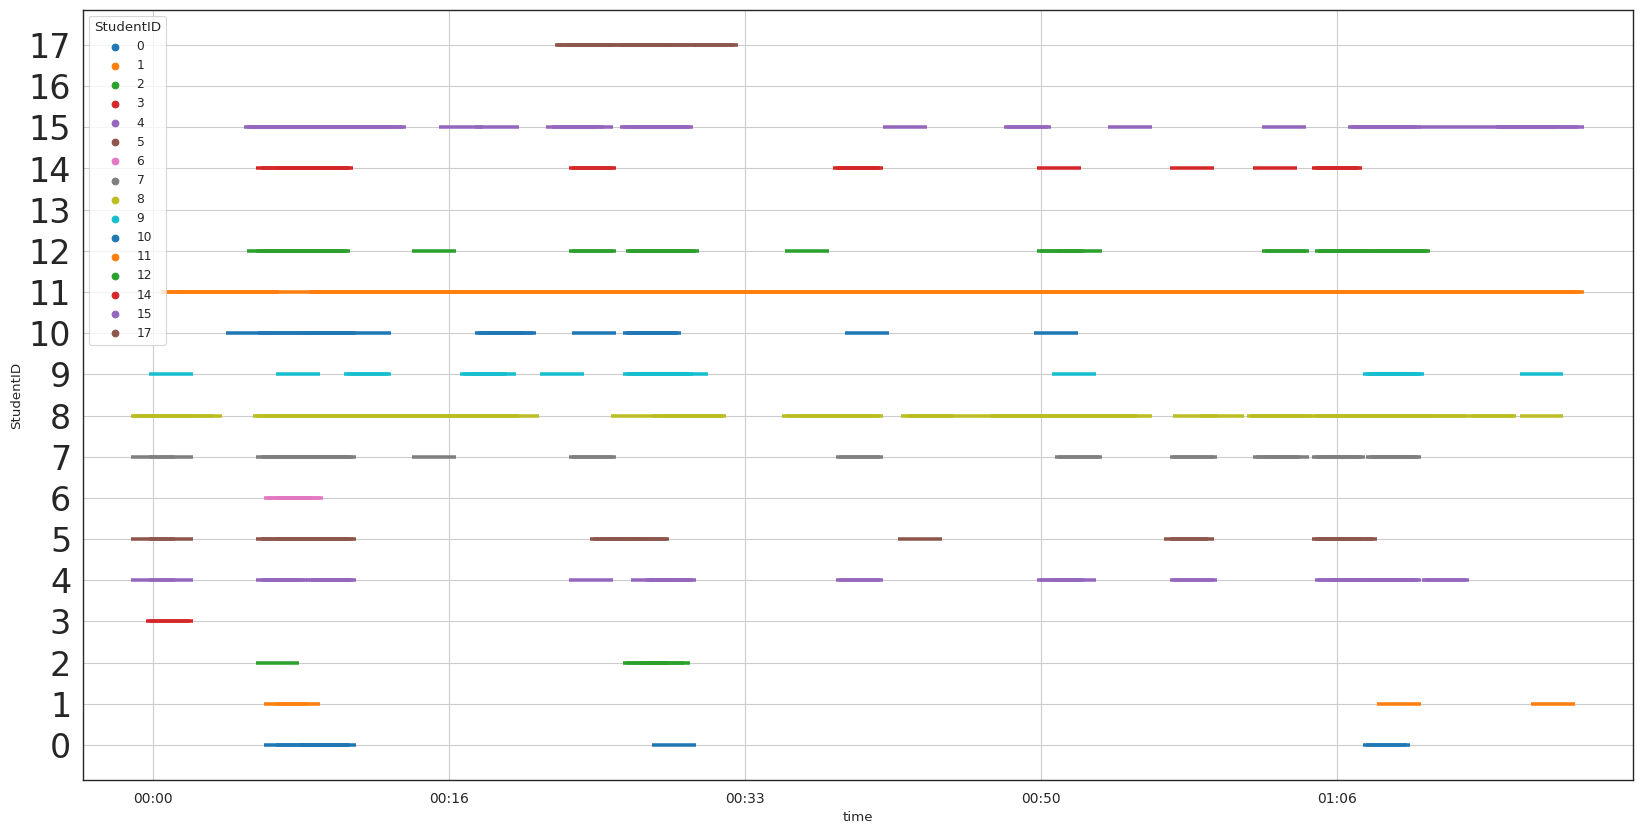

In [182]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(df_gaze, y='StudentID',x='time',hue='StudentID',palette='tab10',s=1000,marker='_')
ax.set_xticklabels([pd.to_datetime(tm*10, unit='s').strftime('%H:%M') for tm in ax.get_xticks()], fontsize=10)
plt.yticks(range(sid_idx), range(sid_idx),fontsize=24)
plt.grid()

# Get Hand Raises and Unique Hand Raises across sessions

In [140]:
# course='05748A'
hand_positions = {'other':0, 'error':0, 'handsOnFace':0, 'armsCrossed':0, 'handsRaised':1}
session_cross_info = []
for session in session_filter_list:
    # if course not in session:
    #     continue
    session_id = f'{session}-front'
    case_study_input_cache_file = f"{case_study_input_data}/{session_id}.pb"
    instructor_ids,gaze_info,emb_info,face_info,posture_info,bbox_info = pickle.load(open(case_study_input_cache_file, 'rb'))
    # get student id level hand raise for this session
    ts_data_dfs = []
    sid_idx = 0
    for sid in sorted(list(posture_info.keys())):
        if sid not in instructor_ids:
            
            handraise_sid = deepcopy(posture_info[sid]).reset_index()
            handraise_sid['time'] = handraise_sid['frame']//(60*15)
            handraise_sid['hand_raised'] = handraise_sid.armPose.apply(lambda x: hand_positions[x])
            handraise_sid = handraise_sid.groupby('time',as_index=False).agg({'hand_raised':lambda x: x.sum()>0})
            handraise_sid = handraise_sid[handraise_sid['hand_raised']==1]
            num_hand_raises = handraise_sid.shape[0]
            
            # hand_face_fraction = posture_info[sid][posture_info[sid].armPose=='handsOnFace'].shape[0]/posture_info[sid].shape[0]
            # arm_crossed_fraction = posture_info[sid][posture_info[sid].armPose=='armsCrossed'].shape[0]/posture_info[sid].shape[0]
            
            gaze_sid = deepcopy(gaze_info[sid]).reset_index()
            gaze_sid['time'] =gaze_sid['frame']//(10*15)
            gaze_sid['gaze_down'] = gaze_sid.pitch< -30
            gaze_sid = gaze_sid.groupby('time',as_index=False).agg({'gaze_down':lambda x: (x.sum()/x.shape[0]) >= 0.5})
            # gaze_sid = gaze_sid[gaze_sid['gaze_down']==1]
            gaze_down_fraction = gaze_sid['gaze_down'].sum()/gaze_sid.shape[0]
            
            # gaze_yaw_median = np.median(gaze_sid.yaw)
            # gaze_yaw_tol = 50
            # gaze_sid['looking_across'] = (gaze_sid.yaw <= (gaze_yaw_median-gaze_yaw_tol)) | (gaze_sid.yaw>=(gaze_yaw_median+gaze_yaw_tol))
            
            # gaze_across_fraction = gaze_sid['looking_across'].sum()/gaze_sid.shape[0]
            # session_cross_info.append([session, sid_idx, num_hand_raises, hand_face_fraction, arm_crossed_fraction, gaze_down_fraction, gaze_across_fraction])
            session_cross_info.append([session, sid_idx, num_hand_raises, gaze_down_fraction])
            sid_idx+=1
# df_session_cross = pd.DataFrame(session_cross_info,columns=['session', 'StudentID','hand_raises','hand_face','arm_cross','looking_down','looking_across'])
df_session_cross = pd.DataFrame(session_cross_info,columns=['session', 'StudentID','hand_raises','looking_down'])
df_session_cross


,session,StudentID,hand_raises,looking_down
0,classinsight-cmu_05748A_ghc_4101_201902141630,0,7,0.217119
1,classinsight-cmu_05748A_ghc_4101_201902141630,1,11,0.000000
2,classinsight-cmu_05748A_ghc_4101_201902141630,2,17,0.014894
3,classinsight-cmu_05748A_ghc_4101_201902141630,3,7,0.049296
4,classinsight-cmu_05748A_ghc_4101_201902141630,4,9,0.018789
...,...,...,...,...
237,classinsight-cmu_17214C_ph_225b_201905011130,14,1,0.104167
238,classinsight-cmu_17214C_ph_225b_201905011130,15,0,0.210145
239,classinsight-cmu_17214C_ph_225b_201905011130,16,1,0.288660
240,classinsight-cmu_17214C_ph_225b_201905011130,17,5,0.156627


In [141]:
session_filter_list

['classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130']

In [142]:
df_session_cross

,session,StudentID,hand_raises,looking_down
0,classinsight-cmu_05748A_ghc_4101_201902141630,0,7,0.217119
1,classinsight-cmu_05748A_ghc_4101_201902141630,1,11,0.000000
2,classinsight-cmu_05748A_ghc_4101_201902141630,2,17,0.014894
3,classinsight-cmu_05748A_ghc_4101_201902141630,3,7,0.049296
4,classinsight-cmu_05748A_ghc_4101_201902141630,4,9,0.018789
...,...,...,...,...
237,classinsight-cmu_17214C_ph_225b_201905011130,14,1,0.104167
238,classinsight-cmu_17214C_ph_225b_201905011130,15,0,0.210145
239,classinsight-cmu_17214C_ph_225b_201905011130,16,1,0.288660
240,classinsight-cmu_17214C_ph_225b_201905011130,17,5,0.156627


# Correlation plot: Gaze Down fraction vs Count Hand Raises

In [170]:
# plt.figure(figsize=(10,10))
# df_session_cross['looking_up']  = 1- df_session_cross['looking_down']
# sns.scatterplot(df_session_cross[df_session_cross.session.isin(session_filter_list[10:15])], x='looking_up', y='hand_raises', hue='session',s=500, palette='tab10',alpha=0.7)
# # plt.xlim(0.8,1.)

In [171]:
# plt.figure(figsize=(10,10))
# df_session_cross['looking_up']  = 1- df_session_cross['looking_down']
# sns.scatterplot(df_session_cross[df_session_cross.session.isin(session_filter_list[10:15])], x='looking_up', y='hand_raises', hue='session',s=500, palette='tab10',alpha=0.7)
# # plt.ylim(0,200)

In [186]:
df_session_cross.to_csv('CS_3A_cross.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   session       242 non-null    object 
 1   StudentID     242 non-null    int64  
 2   hand_raises   242 non-null    int64  
 3   looking_down  242 non-null    float64
 4   looking_up    242 non-null    float64
 5   course        242 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 11.5+ KB


(0.0, 25.0)

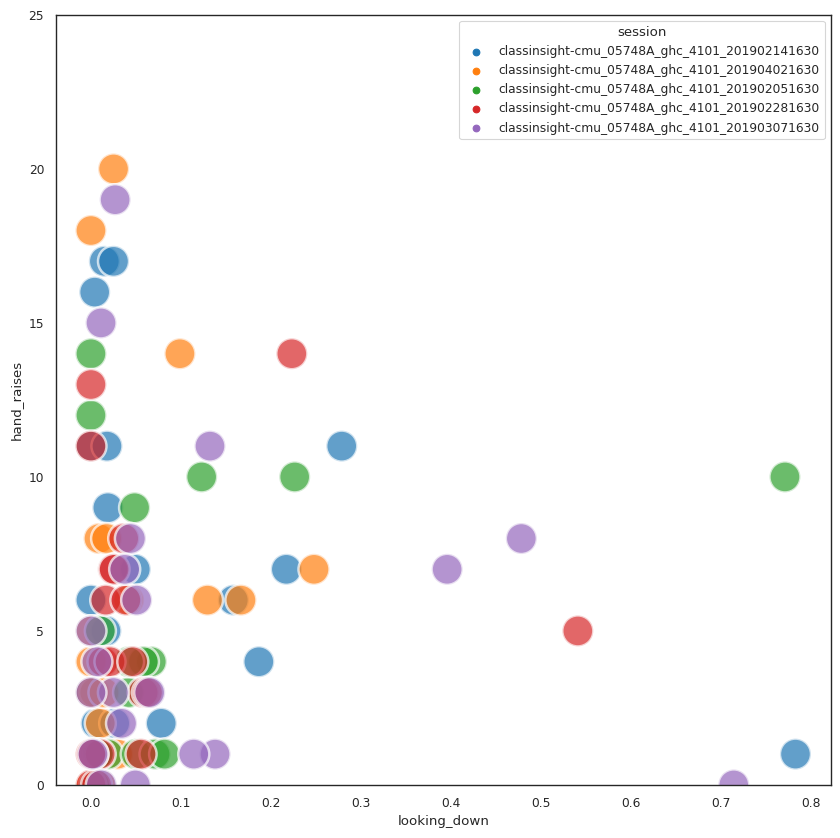

In [190]:
df_session_cross.info()
df_session_cross['course'] = df_session_cross['session'].apply(lambda x: x.split("_")[-4])
plt.figure(figsize=(10,10))
df_session_cross['looking_up']  = 1- df_session_cross['looking_down']
sns.scatterplot(df_session_cross[df_session_cross.session.isin(session_filter_list[0:5])], x='looking_down', y='hand_raises', hue='session',s=500, palette='tab10',alpha=0.7)
plt.ylim(0,25)

In [172]:
# df_session_cross[df_session_cross.session.isin(session_filter_list[0:1]+session_filter_list[5:6])]

In [173]:
# plt.figure(figsize=(10,10))
# df_session_cross['looking_up']  = 1- df_session_cross['looking_down']
# sns.scatterplot(df_session_cross, x='looking_down', y='hand_raises', hue='course',s=500, palette='tab10',alpha=0.7)
# plt.ylim(0,200)

In [174]:
# plt.figure(figsize=(10,10))
# df_session_cross['looking_up']  = 1- df_session_cross['looking_down']
# sns.scatterplot(df_session_cross[df_session_cross.session.isin(session_filter_list[:3])], x='looking_down', y='looking_across', hue='session',s=50, palette='tab10',alpha=0.7)
# plt.ylim(0,0.5)
# plt.xlim(0,0.5)